In [1]:
from numpy.linalg import inv
import numpy as np
import matplotlib.pyplot as plt
import math
from math import e
from math import log
from numpy import linalg
import sys
import sympy
from sympy import *
from IPython.display import display, HTML
import random
from math import log
from math import exp

%matplotlib inline
%config IPCompleter.greedy=True
sympy.init_printing(use_unicode=False, wrap_line=True)
np.set_printoptions(suppress=True)

from utils import *

In [2]:
# Load mnist data
print('Load Data...', end=' ')
imgs_train, labels_train = load_mnist(train=True)
imgs_test, labels_test = load_mnist(train=False)

# Change Image to Feature Vector
X_train, Y_train = img_to_vector(imgs_train), labels_train
X_test, Y_test = img_to_vector(imgs_test), labels_test

print('Finish!')

Load Data... Finish!


In [3]:
print(X_train.shape)
print(max(X_train[0]))

(60000, 784)
255.0


In [4]:
# E-Step : Compute the probabilities of cluster assignment (r_ik)
# M-step : Update parameters mu, pi givn r 

# X = [[x_11...x_1d], ..., [x_n1...x_nd]] where x_ij = 0/1 (success/fail)
# mu : [mu_1...mu_k] where mu_i is the vector of prob of success for cluster k , mu_i's shape = (1, D)
# pi : [pi_1 ... pi_k] where pi_i is the prob to draw cluster k
# r_iK : the prob(expectation) that Xi belong to cluster k
# Zi : [z_i1, ..., z_ik] binary k=dim data(assign to cluster k)

![title](formula.PNG)

In [5]:
num_cluster = 10
K = num_cluster
X = np.copy(X_test)[:]
Y = np.copy(Y_test)[:]
N, D = X.shape
# init parameters mu & pi
mu = np.random.random((K, D))
pi = np.random.random((K, 1)) 
pi = pi / pi.sum()
r = np.zeros((N,K))
print(X.max())
print(X.min())

255.0
0.0


In [6]:
# 0~255 to 0 or 1
X[X<128.0] = 0
X[X>=128.0] = 1
print(X.max())
print(X.min())

1.0
0.0


In [10]:
from numpy import prod
from tqdm.notebook import tqdm
import time
def L2distance(A,B):
    A = A.reshape(prod(A.shape))
    B = B.reshape(prod(B.shape))
    dis = math.sqrt(np.dot(A-B, A-B))
    return dis

def EM(X, mu, pi, r, max_iter=10):
    
    N, D = X.shape
    K, _ = mu.shape
    
    new_mu = np.copy(mu)
    
    
    for it in range(max_iter):
        # E-Step : Compute the probabilities of cluster assignment (r_ik)
        pbar = tqdm(total=N, unit='instance') # for progress bar
        pbar.set_description('E-Step(iteration %d)' % (it)) # for progress bar
        for i in range(N):
            for k in range(K):
                r[i][k] = log(pi[k]) # Log scale
                for d in range(D):
                    xid = X[i][d]
                    try:
                        r[i][k] += log((mu[k][d]**xid) * ((1-mu[k][d])**(1-xid))+1e-7)
                    except:
                        print('domain error')
                        print(mu[k][d], xid)
                        print((mu[k][d]**xid) * ((1-mu[k][d])**(1-xid)))
            r[i] -= r[i].max()
            r[i] = np.exp(r[i]) # Exp, back to origin scale
            r[i] = r[i] / r[i].sum() # normalize to 1 
            
            pbar.update() # for progress bar
        Nk = r.sum(axis=0)  # prob to draw k-th cluster
        pi = Nk/Nk.sum()
        pbar.close() # for progress bar
        time.sleep(1) # for progress bar
        # M-step : Update parameters mu, pi givn r 
        pbar = tqdm(total=K, unit='cluster') # for progress bar
        pbar.set_description('M-Step(iteration %d)' % (it)) # for progress bar
        for k in range(K):
            mu_k = 0
            for i in range(N):
                mu_k += r[i][k] * X[i]
            new_mu[k] = mu_k / Nk[k]
            pbar.update() # for progress bar
        diff = L2distance(new_mu, mu)
        print('L2 Distance Between old & new mu : ', diff ) 
        mu = np.copy(new_mu)
        if diff < 1e-5:
            print('converge after %d iteration'%(it))
            break
        pbar.close() # for progress bar
        time.sleep(1) # for progress bar
    return mu, pi, r

def EM_inference(X, mu, pi):
    N, D = X.shape
    K, _ = mu.shape
    y_pred = np.zeros((N,))
    pbar = tqdm(total=N, unit='instance') # for progress bar
    #pbar.set_description('E-Step(iteration %d)' % (it)) # for progress bar
    for i in range(N):
        for k in range(K):
            r[i][k] = log(pi[k]) # Log scale
            for d in range(D):
                xid = X[i][d]
                try:
                    r[i][k] += log((mu[k][d]**xid) * ((1-mu[k][d])**(1-xid))+1e-7)
                except:
                    print('domain error')
                    print(mu[k][d], xid)
                    print((mu[k][d]**xid) * ((1-mu[k][d])**(1-xid)))
#         print(r[i])
        y_pred[i] = np.argmax(r[i]) 
        pbar.update() # for progress bar
    pbar.close() # for progress bar
    time.sleep(1) # for progress bar
    return y_pred

In [8]:
mu, pi, r = EM(X, mu, pi, r)

L2 Distance Between old & new mu :  44.692915891122276



L2 Distance Between old & new mu :  5.696065477978344



L2 Distance Between old & new mu :  2.97879043014088



L2 Distance Between old & new mu :  2.3994810586294792



L2 Distance Between old & new mu :  2.1101584086237617



L2 Distance Between old & new mu :  1.5936834822856467



L2 Distance Between old & new mu :  1.2630096012722465



L2 Distance Between old & new mu :  1.0973134378187792



L2 Distance Between old & new mu :  1.091828312120765



L2 Distance Between old & new mu :  0.8907076691176837



In [11]:
y_pred = EM_inference(X, mu, pi)

In [12]:
from sklearn.metrics import confusion_matrix

count_y = [np.count_nonzero(Y == i) for i in range(10)]
count_y_pred = [np.count_nonzero(y_pred == i) for i in range(num_cluster)]
print(count_y)
print(count_y_pred)

print(confusion_matrix(y_pred, Y))

[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]
[1260, 1533, 851, 1, 1112, 1736, 1596, 1, 854, 1056]
[[ 101    1   35  646    0  346   28    0   96    7]
 [   1   18   12   33  440   26    5  420   14  564]
 [  16    4   22    3   20    8  770    1    6    1]
 [   0    0    0    0    0    0    0    0    0    1]
 [  26    6  148  232    7  179    4    9  488   13]
 [  17    0    9   21  368  211    2  528  230  350]
 [   2 1104   72   48   23   93   63   55  114   22]
 [   0    0    0    0    0    0    1    0    0    0]
 [ 806    0   10    2    1    9   13    1    5    7]
 [  11    2  724   25  123   20   72   14   21   44]]


In [13]:
print(r.shape)
print(mu.shape)

(10000, 10)
(10, 784)


In [14]:
# print(Nk)
# print(Nk.sum())
# print(Nk/Nk.sum())

In [15]:
print(mu.max())
print(mu.min())

1.0
0.0


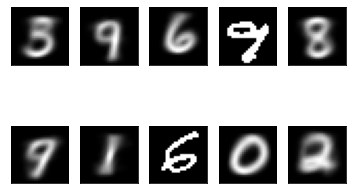

In [16]:
for i in range(num_cluster):
    plt.subplot(2,5,i+1)
    p = mu[i].reshape((28,28))
    plt.imshow(p, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.show()